In [1]:
import os
import shutil

import torch
import numpy as np
from torch import nn
from torchvision.transforms import transforms

import yaml

import logging
import sys
import csv
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast

from tqdm import tqdm

In [2]:

torch.manual_seed(0)
np.random.seed(0)

# Utils

In [3]:

class GaussianBlur(object):
    """blur a single image on CPU"""
    def __init__(self, kernel_size):
        radias = kernel_size // 2
        kernel_size = radias * 2 + 1
        self.blur_h = nn.Conv2d(3, 3, kernel_size=(kernel_size, 1),
                                stride=1, padding=0, bias=False, groups=3)
        self.blur_v = nn.Conv2d(3, 3, kernel_size=(1, kernel_size),
                                stride=1, padding=0, bias=False, groups=3)
        self.k = kernel_size
        self.r = radias

        self.blur = nn.Sequential(
            nn.ReflectionPad2d(radias),
            self.blur_h,
            self.blur_v
        )

        self.pil_to_tensor = transforms.ToTensor()
        self.tensor_to_pil = transforms.ToPILImage()

    def __call__(self, img):
        img = self.pil_to_tensor(img).unsqueeze(0)

        sigma = np.random.uniform(0.1, 2.0)
        x = np.arange(-self.r, self.r + 1)
        x = np.exp(-np.power(x, 2) / (2 * sigma * sigma))
        x = x / x.sum()
        x = torch.from_numpy(x).view(1, -1).repeat(3, 1)

        self.blur_h.weight.data.copy_(x.view(3, 1, self.k, 1))
        self.blur_v.weight.data.copy_(x.view(3, 1, 1, self.k))

        with torch.no_grad():
            img = self.blur(img)
            img = img.squeeze()

        img = self.tensor_to_pil(img)

        return img
        
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def save_config_file(model_checkpoints_folder, args):
    if not os.path.exists(model_checkpoints_folder):
        os.makedirs(model_checkpoints_folder)
        with open(os.path.join(model_checkpoints_folder, 'config.yml'), 'w') as outfile:
            yaml.dump(args, outfile, default_flow_style=False)


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


# SimCLR

In [4]:

class SimCLR(object):

    def __init__(self, *args, **kwargs):
        self.args = kwargs['args']
        self.model = kwargs['model'].to(self.args.device)
        self.optimizer = kwargs['optimizer']
        self.scheduler = kwargs['scheduler']
        # self.writer = SummaryWriter()
        # logging.basicConfig(filename=os.path.join(self.writer.log_dir, 'training.log'), level=logging.DEBUG)
        self.criterion = torch.nn.CrossEntropyLoss().to(self.args.device)

        os.makedirs(self.args.log_dir, exist_ok=True)
        logging.basicConfig(filename=os.path.join(self.args.log_dir, 'training.log'),
                            level=logging.INFO,
                            format='%(asctime)s - %(levelname)s - %(message)s')

        self.csv_log_path = os.path.join(self.args.log_dir, 'metrics.csv')
        with open(self.csv_log_path, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['step', 'loss', 'acc_top1', 'acc_top5', 'learning_rate'])

        

    def info_nce_loss(self, features):

        labels = torch.cat([torch.arange(self.args.batch_size) for i in range(self.args.n_views)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(self.args.device)

        features = F.normalize(features, dim=1)

        similarity_matrix = torch.matmul(features, features.T)
        # assert similarity_matrix.shape == (
        #     self.args.n_views * self.args.batch_size, self.args.n_views * self.args.batch_size)
        # assert similarity_matrix.shape == labels.shape

        # discard the main diagonal from both: labels and similarities matrix
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(self.args.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
        # assert similarity_matrix.shape == labels.shape

        # select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # select only the negatives the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.args.device)

        logits = logits / self.args.temperature
        return logits, labels

    def train(self, train_loader):

        scaler = GradScaler(enabled=self.args.fp16_precision)

        # save config file
        # save_config_file(self.writer.log_dir, self.args)

        n_iter = 0
        best_top1 = 0.0  
        logging.info(f"Start SimCLR training for {self.args.epochs} epochs.")

        for epoch_counter in range(self.args.epochs):
            for images, _ in tqdm(train_loader):
                images = torch.cat(images, dim=0)

                images = images.to(self.args.device)

                with autocast(enabled=self.args.fp16_precision):
                    features = self.model(images)
                    logits, labels = self.info_nce_loss(features)
                    loss = self.criterion(logits, labels)

                self.optimizer.zero_grad()

                scaler.scale(loss).backward()

                scaler.step(self.optimizer)
                scaler.update()

                if n_iter % self.args.log_every_n_steps == 0:
                    top1, top5 = accuracy(logits, labels, topk=(1, 5))
                    lr = self.scheduler.get_last_lr()[0]

                    print(f"[Epoch {epoch_counter+1}] Step {n_iter}: Loss={loss:.4f}, Top1={top1[0]:.2f}%, Top5={top5[0]:.2f}%, LR={lr:.6f}")


                    # File log
                    with open(self.csv_log_path, mode='a', newline='') as f:
                        writer = csv.writer(f)
                        writer.writerow([n_iter, loss.item(), top1[0].item(), top5[0].item(), lr])

                    if top1[0].item() > best_top1:
                        best_top1 = top1[0].item()
                        best_ckpt_path = os.path.join(self.args.log_dir, 'checkpoint_best.pth')
                        save_checkpoint({
                            'epoch': epoch_counter + 1,
                            'arch': self.args.arch,
                            'state_dict': self.model.state_dict(),
                            'optimizer': self.optimizer.state_dict(),
                            'best_top1': best_top1
                        }, is_best=True, filename=best_ckpt_path)
                        logging.info(f"New best model saved with Top1={best_top1:.2f}% at epoch {epoch_counter+1}, step {n_iter}")

                    

                n_iter += 1

            # warmup for the first 10 epochs
            if epoch_counter >= 10:
                self.scheduler.step()
            logging.debug(f"Epoch: {epoch_counter}\tLoss: {loss}\tTop1 accuracy: {top1[0]}")

        logging.info("Training has finished.")
        # save model checkpoints
        checkpoint_name = os.path.join(self.args.log_dir, f'checkpoint_{self.args.epochs:04d}.pth.tar')
        
        save_checkpoint({
            'epoch': self.args.epochs,
            'arch': self.args.arch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
        }, is_best=False, filename=checkpoint_name)
        

# Exceptions

In [5]:
class BaseSimCLRException(Exception):
    """Base exception"""


class InvalidBackboneError(BaseSimCLRException):
    """Raised when the choice of backbone Convnet is invalid."""


class InvalidDatasetSelection(BaseSimCLRException):
    """Raised when the choice of dataset is invalid."""


# Dataset

In [6]:
class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transform(x) for i in range(self.n_views)]

In [7]:
from torchvision.transforms import transforms
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from PIL import Image

# Pastikan class GaussianBlur dan ContrastiveLearningViewGenerator sudah ada dari sel sebelumnya

class ContrastiveLearningDataset:
    def __init__(self, root_folder):
        self.root_folder = root_folder

    @staticmethod
    def get_simclr_pipeline_transform(size, s=1):
        """Return a set of data augmentation transformations as described in the SimCLR paper."""
        color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
        data_transforms = transforms.Compose([
            transforms.RandomResizedCrop(size=size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            GaussianBlur(kernel_size=int(0.1 * size)),
            transforms.ToTensor()
        ])
        return data_transforms

    def get_dataset(self, name, n_views):
        valid_datasets = {
            'cifar10': lambda: datasets.CIFAR10(
                self.root_folder, train=True,
                transform=ContrastiveLearningViewGenerator(self.get_simclr_pipeline_transform(32), n_views),
                download=True
            ),
            'stl10': lambda: datasets.STL10(
                self.root_folder, split='unlabeled',
                transform=ContrastiveLearningViewGenerator(self.get_simclr_pipeline_transform(96), n_views),
                download=True
            ),
            'tinyimagenet': lambda: ImageFolder(
                root=os.path.join(self.root_folder, 'tiny-imagenet-200', 'train'),
                transform=ContrastiveLearningViewGenerator(self.get_simclr_pipeline_transform(64), n_views)
            )
        }

        try:
            dataset_fn = valid_datasets[name]
        except KeyError:
            # Pastikan class InvalidDatasetSelection sudah didefinisikan
            raise InvalidDatasetSelection()
        else:
            return dataset_fn()

# Encoder Model

In [8]:

import torchvision.models as models



class ResNetSimCLR(nn.Module):

    def __init__(self, base_model, out_dim):
        super(ResNetSimCLR, self).__init__()
        self.resnet_dict = {"resnet18": models.resnet18(weights=None, num_classes=out_dim),
                            "resnet50": models.resnet50(weights=None, num_classes=out_dim)}

        self.backbone = self._get_basemodel(base_model)
        dim_mlp = self.backbone.fc.in_features

        # add mlp projection head
        self.backbone.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.backbone.fc)

    def _get_basemodel(self, model_name):
        try:
            model = self.resnet_dict[model_name]
        except KeyError:
            raise InvalidBackboneError(
                "Invalid backbone architecture. Check the config file and pass one of: resnet18 or resnet50")
        else:
            return model

    def forward(self, x):
        return self.backbone(x)


# Main

In [9]:

model_names = sorted(name for name in models.__dict__
                     if name.islower() and not name.startswith("__")
                     and callable(models.__dict__[name]))
print(model_names)

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'get_model', 'get_model_builder', 'get_model_weights', 'get_weight', 'googlenet', 'inception_v3', 'list_models', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_

In [10]:
from types import SimpleNamespace
import torch.backends.cudnn as cudnn
import torch
from torch.utils.data import DataLoader

# Pastikan class ContrastiveLearningDataset dan ResNetSimCLR sudah didefinisikan di sel sebelumnya

# Konfigurasi Eksperimen
args = SimpleNamespace()
args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.data = '/kaggle/input/tiny-imagenet/tiny-imagenet-200'
args.dataset_name = 'tinyimagenet'
args.arch = 'resnet50'  # Diubah dari resnet18 ke resnet50 sebagai contoh modifikasi
args.n_views = 2
args.batch_size = 256
args.out_dim = 128
args.lr = 0.0003
args.weight_decay = 1e-4
args.epochs = 50
args.temperature = 0.07
args.workers = 2
args.gpu_index = 0
args.log_dir = '/kaggle/working/logs/simclr'
args.fp16_precision = True
args.seed = 1
args.log_every_n_steps = 100

# Mengatur CUDA untuk hasil yang deterministik
cudnn.deterministic = True
cudnn.benchmark = True

# Inisialisasi Dataset dan DataLoader
dataset = ContrastiveLearningDataset(args.data)
train_dataset = dataset.get_dataset(args.dataset_name, args.n_views)

train_loader = DataLoader(
    train_dataset, 
    batch_size=args.batch_size, 
    shuffle=True,
    num_workers=args.workers, 
    pin_memory=True, 
    drop_last=True
)

# Inisialisasi Model
model = ResNetSimCLR(base_model=args.arch, out_dim=args.out_dim)

# Inisialisasi Optimizer
optimizer = torch.optim.Adam(model.parameters(), args.lr, weight_decay=args.weight_decay)

# Inisialisasi Scheduler (Pengatur Learning Rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=len(train_loader), 
    eta_min=0,
    last_epoch=-1
)

print("Setup selesai. Siap untuk memulai training.")

Setup selesai. Siap untuk memulai training.


In [11]:
with torch.cuda.device(args.gpu_index):
    simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, args=args)
    simclr.train(train_loader)

/tmp/ipykernel_36/943341053.py:57: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=self.args.fp16_precision)
  0%|          | 0/390 [00:00<?, ?it/s]/tmp/ipykernel_36/943341053.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.fp16_precision):
  0%|          | 1/390 [00:19<2:03:55, 19.11s/it]

[Epoch 1] Step 0: Loss=6.2530, Top1=0.00%, Top5=2.15%, LR=0.000300


 26%|██▌       | 100/390 [02:49<08:26,  1.75s/it]

[Epoch 1] Step 100: Loss=6.1492, Top1=0.39%, Top5=6.45%, LR=0.000300


 51%|█████▏    | 200/390 [05:24<05:33,  1.76s/it]

[Epoch 1] Step 200: Loss=5.9699, Top1=1.37%, Top5=5.86%, LR=0.000300


 77%|███████▋  | 301/390 [07:57<01:56,  1.31s/it]

[Epoch 1] Step 300: Loss=5.8932, Top1=1.17%, Top5=4.30%, LR=0.000300


  3%|▎         | 10/390 [00:10<05:37,  1.13it/s]

[Epoch 2] Step 400: Loss=5.7734, Top1=2.15%, Top5=7.81%, LR=0.000300


 28%|██▊       | 110/390 [01:52<04:05,  1.14it/s]

[Epoch 2] Step 500: Loss=5.6888, Top1=2.54%, Top5=9.77%, LR=0.000300


 54%|█████▍    | 210/390 [03:32<02:37,  1.14it/s]

[Epoch 2] Step 600: Loss=5.6547, Top1=4.69%, Top5=14.45%, LR=0.000300


 80%|███████▉  | 311/390 [05:16<01:34,  1.20s/it]

[Epoch 2] Step 700: Loss=5.4599, Top1=4.49%, Top5=12.89%, LR=0.000300


  5%|▌         | 20/390 [00:20<05:17,  1.17it/s]

[Epoch 3] Step 800: Loss=5.4575, Top1=5.08%, Top5=14.65%, LR=0.000300


 31%|███       | 121/390 [02:02<05:14,  1.17s/it]

[Epoch 3] Step 900: Loss=5.3613, Top1=3.52%, Top5=15.23%, LR=0.000300


 56%|█████▋    | 220/390 [03:40<02:38,  1.07it/s]

[Epoch 3] Step 1000: Loss=5.2868, Top1=8.01%, Top5=20.12%, LR=0.000300


 82%|████████▏ | 321/390 [05:23<01:19,  1.15s/it]

[Epoch 3] Step 1100: Loss=4.9229, Top1=5.66%, Top5=23.83%, LR=0.000300


  8%|▊         | 31/390 [00:31<06:38,  1.11s/it]

[Epoch 4] Step 1200: Loss=5.0542, Top1=7.03%, Top5=19.53%, LR=0.000300


 34%|███▎      | 131/390 [02:10<04:40,  1.08s/it]

[Epoch 4] Step 1300: Loss=5.0307, Top1=8.01%, Top5=21.48%, LR=0.000300


 59%|█████▉    | 230/390 [03:45<02:16,  1.17it/s]

[Epoch 4] Step 1400: Loss=5.0599, Top1=11.52%, Top5=24.41%, LR=0.000300


 85%|████████▍ | 331/390 [05:25<01:06,  1.13s/it]

[Epoch 4] Step 1500: Loss=4.9693, Top1=10.55%, Top5=24.41%, LR=0.000300


 11%|█         | 41/390 [00:41<06:27,  1.11s/it]

[Epoch 5] Step 1600: Loss=4.9625, Top1=10.94%, Top5=25.98%, LR=0.000300


 36%|███▌      | 140/390 [02:18<03:42,  1.12it/s]

[Epoch 5] Step 1700: Loss=4.7215, Top1=12.70%, Top5=30.47%, LR=0.000300


 62%|██████▏   | 241/390 [03:57<02:32,  1.03s/it]

[Epoch 5] Step 1800: Loss=4.7659, Top1=9.18%, Top5=28.91%, LR=0.000300


 87%|████████▋ | 341/390 [05:34<00:44,  1.10it/s]

[Epoch 5] Step 1900: Loss=4.9537, Top1=8.59%, Top5=26.56%, LR=0.000300


 13%|█▎        | 50/390 [00:47<04:41,  1.21it/s]

[Epoch 6] Step 2000: Loss=4.7793, Top1=14.65%, Top5=27.54%, LR=0.000300


 39%|███▊      | 151/390 [02:23<04:06,  1.03s/it]

[Epoch 6] Step 2100: Loss=4.6073, Top1=14.65%, Top5=31.84%, LR=0.000300


 64%|██████▍   | 250/390 [03:55<01:55,  1.22it/s]

[Epoch 6] Step 2200: Loss=4.5878, Top1=16.02%, Top5=33.20%, LR=0.000300


 90%|█████████ | 351/390 [05:30<00:41,  1.06s/it]

[Epoch 6] Step 2300: Loss=4.6546, Top1=11.13%, Top5=33.01%, LR=0.000300


 15%|█▌        | 60/390 [00:56<04:34,  1.20it/s]

[Epoch 7] Step 2400: Loss=4.3404, Top1=17.97%, Top5=38.87%, LR=0.000300


 41%|████      | 160/390 [02:30<03:15,  1.18it/s]

[Epoch 7] Step 2500: Loss=4.4051, Top1=20.12%, Top5=37.70%, LR=0.000300


 67%|██████▋   | 260/390 [04:05<01:46,  1.22it/s]

[Epoch 7] Step 2600: Loss=4.2337, Top1=21.29%, Top5=40.43%, LR=0.000300


 93%|█████████▎| 361/390 [05:44<00:29,  1.03s/it]

[Epoch 7] Step 2700: Loss=4.3280, Top1=17.19%, Top5=36.33%, LR=0.000300


 18%|█▊        | 71/390 [01:06<05:20,  1.00s/it]

[Epoch 8] Step 2800: Loss=4.2427, Top1=19.92%, Top5=39.84%, LR=0.000300


 44%|████▎     | 170/390 [02:37<03:19,  1.10it/s]

[Epoch 8] Step 2900: Loss=4.1431, Top1=25.20%, Top5=41.80%, LR=0.000300


 69%|██████▉   | 271/390 [04:10<01:36,  1.23it/s]

[Epoch 8] Step 3000: Loss=3.9933, Top1=22.46%, Top5=42.77%, LR=0.000300


 95%|█████████▌| 371/390 [05:44<00:16,  1.18it/s]

[Epoch 8] Step 3100: Loss=4.1574, Top1=16.99%, Top5=41.02%, LR=0.000300


 21%|██        | 80/390 [01:12<03:59,  1.30it/s]

[Epoch 9] Step 3200: Loss=3.9373, Top1=25.98%, Top5=46.29%, LR=0.000300


 46%|████▋     | 181/390 [02:46<03:52,  1.11s/it]

[Epoch 9] Step 3300: Loss=4.0754, Top1=20.12%, Top5=40.04%, LR=0.000300


 72%|███████▏  | 281/390 [04:24<02:02,  1.12s/it]

[Epoch 9] Step 3400: Loss=3.7078, Top1=24.41%, Top5=47.07%, LR=0.000300


 97%|█████████▋| 380/390 [06:01<00:08,  1.19it/s]

[Epoch 9] Step 3500: Loss=3.8091, Top1=26.17%, Top5=46.88%, LR=0.000300


 23%|██▎       | 90/390 [01:33<04:29,  1.11it/s]

[Epoch 10] Step 3600: Loss=3.8629, Top1=26.76%, Top5=48.24%, LR=0.000300


 49%|████▊     | 190/390 [03:17<03:03,  1.09it/s]

[Epoch 10] Step 3700: Loss=3.8530, Top1=27.93%, Top5=49.02%, LR=0.000300


 74%|███████▍  | 290/390 [05:00<01:29,  1.12it/s]

[Epoch 10] Step 3800: Loss=4.0262, Top1=28.71%, Top5=46.88%, LR=0.000300


  0%|          | 0/390 [00:00<?, ?it/s]

[Epoch 11] Step 3900: Loss=3.8775, Top1=28.91%, Top5=49.61%, LR=0.000300


 26%|██▌       | 101/390 [01:46<05:37,  1.17s/it]

[Epoch 11] Step 4000: Loss=3.8854, Top1=27.93%, Top5=47.27%, LR=0.000300


 52%|█████▏    | 201/390 [03:29<03:41,  1.17s/it]

[Epoch 11] Step 4100: Loss=3.6502, Top1=26.95%, Top5=50.59%, LR=0.000300


 77%|███████▋  | 300/390 [05:09<01:20,  1.12it/s]

[Epoch 11] Step 4200: Loss=3.5392, Top1=33.01%, Top5=56.45%, LR=0.000300


  3%|▎         | 10/390 [00:11<05:45,  1.10it/s]

[Epoch 12] Step 4300: Loss=3.5183, Top1=33.59%, Top5=54.30%, LR=0.000300


 28%|██▊       | 111/390 [01:55<05:28,  1.18s/it]

[Epoch 12] Step 4400: Loss=3.8905, Top1=29.69%, Top5=47.46%, LR=0.000300


 54%|█████▍    | 211/390 [03:38<03:26,  1.15s/it]

[Epoch 12] Step 4500: Loss=3.6530, Top1=32.03%, Top5=55.27%, LR=0.000300


 80%|███████▉  | 311/390 [05:21<01:32,  1.17s/it]

[Epoch 12] Step 4600: Loss=3.4408, Top1=29.88%, Top5=53.12%, LR=0.000300


  5%|▌         | 20/390 [00:21<05:40,  1.09it/s]

[Epoch 13] Step 4700: Loss=3.3880, Top1=37.11%, Top5=55.08%, LR=0.000300


 31%|███       | 121/390 [02:05<05:10,  1.15s/it]

[Epoch 13] Step 4800: Loss=3.6499, Top1=31.45%, Top5=52.34%, LR=0.000300


 57%|█████▋    | 221/390 [03:47<03:00,  1.07s/it]

[Epoch 13] Step 4900: Loss=3.3840, Top1=34.18%, Top5=57.62%, LR=0.000300


 82%|████████▏ | 321/390 [05:30<01:15,  1.09s/it]

[Epoch 13] Step 5000: Loss=3.5122, Top1=34.77%, Top5=53.12%, LR=0.000300


  8%|▊         | 31/390 [00:32<06:48,  1.14s/it]

[Epoch 14] Step 5100: Loss=3.3236, Top1=36.72%, Top5=57.62%, LR=0.000300


 34%|███▎      | 131/390 [02:14<05:17,  1.23s/it]

[Epoch 14] Step 5200: Loss=3.4916, Top1=35.35%, Top5=57.62%, LR=0.000300


 59%|█████▉    | 230/390 [03:55<02:23,  1.11it/s]

[Epoch 14] Step 5300: Loss=3.1385, Top1=41.99%, Top5=61.72%, LR=0.000300


 85%|████████▍ | 331/390 [05:39<01:07,  1.14s/it]

[Epoch 14] Step 5400: Loss=3.5021, Top1=34.18%, Top5=55.08%, LR=0.000300


 11%|█         | 41/390 [00:42<06:27,  1.11s/it]

[Epoch 15] Step 5500: Loss=3.1408, Top1=41.21%, Top5=58.79%, LR=0.000300


 36%|███▌      | 141/390 [02:23<04:39,  1.12s/it]

[Epoch 15] Step 5600: Loss=3.2023, Top1=38.87%, Top5=61.72%, LR=0.000300


 62%|██████▏   | 241/390 [04:05<02:47,  1.13s/it]

[Epoch 15] Step 5700: Loss=3.2569, Top1=41.80%, Top5=60.94%, LR=0.000300


 87%|████████▋ | 341/390 [05:45<00:55,  1.14s/it]

[Epoch 15] Step 5800: Loss=3.2612, Top1=37.70%, Top5=58.98%, LR=0.000300


 13%|█▎        | 50/390 [00:50<05:02,  1.13it/s]

[Epoch 16] Step 5900: Loss=2.9424, Top1=42.97%, Top5=63.87%, LR=0.000300


 39%|███▊      | 151/390 [02:34<04:03,  1.02s/it]

[Epoch 16] Step 6000: Loss=2.9540, Top1=41.80%, Top5=63.87%, LR=0.000300


 64%|██████▍   | 250/390 [04:13<02:38,  1.13s/it]

[Epoch 16] Step 6100: Loss=3.1728, Top1=45.31%, Top5=60.35%, LR=0.000300


 90%|█████████ | 351/390 [05:56<00:33,  1.17it/s]

[Epoch 16] Step 6200: Loss=3.2090, Top1=39.06%, Top5=59.57%, LR=0.000300


 15%|█▌        | 60/390 [01:01<04:42,  1.17it/s]

[Epoch 17] Step 6300: Loss=2.9633, Top1=47.27%, Top5=64.26%, LR=0.000300


 41%|████▏     | 161/390 [02:44<04:19,  1.13s/it]

[Epoch 17] Step 6400: Loss=3.0282, Top1=43.16%, Top5=62.89%, LR=0.000300


 67%|██████▋   | 261/390 [04:24<02:23,  1.11s/it]

[Epoch 17] Step 6500: Loss=3.2344, Top1=38.28%, Top5=60.16%, LR=0.000300


 93%|█████████▎| 361/390 [06:03<00:32,  1.11s/it]

[Epoch 17] Step 6600: Loss=2.9737, Top1=41.99%, Top5=62.50%, LR=0.000300


 18%|█▊        | 71/390 [01:11<05:51,  1.10s/it]

[Epoch 18] Step 6700: Loss=2.8357, Top1=46.48%, Top5=66.80%, LR=0.000300


 44%|████▍     | 171/390 [02:51<03:42,  1.02s/it]

[Epoch 18] Step 6800: Loss=2.9904, Top1=40.62%, Top5=65.43%, LR=0.000300


 69%|██████▉   | 270/390 [04:27<01:59,  1.01it/s]

[Epoch 18] Step 6900: Loss=2.8681, Top1=47.46%, Top5=67.38%, LR=0.000300


 95%|█████████▌| 371/390 [06:07<00:19,  1.03s/it]

[Epoch 18] Step 7000: Loss=2.8727, Top1=45.90%, Top5=68.75%, LR=0.000300


 21%|██        | 81/390 [01:20<05:36,  1.09s/it]

[Epoch 19] Step 7100: Loss=3.1926, Top1=40.04%, Top5=59.77%, LR=0.000300


 46%|████▋     | 181/390 [02:58<03:38,  1.05s/it]

[Epoch 19] Step 7200: Loss=2.7602, Top1=47.46%, Top5=65.82%, LR=0.000300


 72%|███████▏  | 281/390 [04:30<01:53,  1.04s/it]

[Epoch 19] Step 7300: Loss=2.8552, Top1=44.53%, Top5=65.04%, LR=0.000300


 98%|█████████▊| 381/390 [05:59<00:08,  1.01it/s]

[Epoch 19] Step 7400: Loss=2.8545, Top1=44.34%, Top5=64.26%, LR=0.000300


 23%|██▎       | 91/390 [01:21<05:02,  1.01s/it]

[Epoch 20] Step 7500: Loss=3.1260, Top1=46.09%, Top5=62.30%, LR=0.000300


 49%|████▉     | 191/390 [02:51<03:02,  1.09it/s]

[Epoch 20] Step 7600: Loss=3.0282, Top1=43.75%, Top5=63.48%, LR=0.000300


 75%|███████▍  | 291/390 [04:24<01:29,  1.11it/s]

[Epoch 20] Step 7700: Loss=3.1055, Top1=42.58%, Top5=59.77%, LR=0.000300


  0%|          | 1/390 [00:02<16:35,  2.56s/it]

[Epoch 21] Step 7800: Loss=3.0164, Top1=44.73%, Top5=63.67%, LR=0.000300


 26%|██▌       | 101/390 [01:42<05:44,  1.19s/it]

[Epoch 21] Step 7900: Loss=3.2240, Top1=40.04%, Top5=60.16%, LR=0.000300


 52%|█████▏    | 201/390 [03:21<03:33,  1.13s/it]

[Epoch 21] Step 8000: Loss=2.8030, Top1=46.09%, Top5=66.02%, LR=0.000300


 77%|███████▋  | 300/390 [04:58<01:17,  1.17it/s]

[Epoch 21] Step 8100: Loss=2.7892, Top1=47.66%, Top5=67.38%, LR=0.000300


  3%|▎         | 10/390 [00:10<05:37,  1.13it/s]

[Epoch 22] Step 8200: Loss=2.8197, Top1=47.85%, Top5=69.53%, LR=0.000299


 28%|██▊       | 111/390 [01:54<05:17,  1.14s/it]

[Epoch 22] Step 8300: Loss=3.0974, Top1=39.45%, Top5=58.79%, LR=0.000299


 54%|█████▍    | 211/390 [03:37<03:21,  1.13s/it]

[Epoch 22] Step 8400: Loss=2.7376, Top1=47.46%, Top5=66.41%, LR=0.000299


 80%|███████▉  | 311/390 [05:19<01:30,  1.14s/it]

[Epoch 22] Step 8500: Loss=2.7236, Top1=47.07%, Top5=66.99%, LR=0.000299


  5%|▌         | 21/390 [00:22<07:22,  1.20s/it]

[Epoch 23] Step 8600: Loss=2.8855, Top1=43.95%, Top5=64.45%, LR=0.000299


 31%|███       | 120/390 [02:02<03:51,  1.17it/s]

[Epoch 23] Step 8700: Loss=2.7173, Top1=49.61%, Top5=66.21%, LR=0.000299


 57%|█████▋    | 221/390 [03:45<03:14,  1.15s/it]

[Epoch 23] Step 8800: Loss=2.9788, Top1=45.31%, Top5=64.84%, LR=0.000299


 82%|████████▏ | 321/390 [05:27<01:18,  1.14s/it]

[Epoch 23] Step 8900: Loss=3.0148, Top1=42.97%, Top5=61.52%, LR=0.000299


  8%|▊         | 31/390 [00:32<06:44,  1.13s/it]

[Epoch 24] Step 9000: Loss=2.7698, Top1=48.24%, Top5=68.95%, LR=0.000299


 33%|███▎      | 130/390 [02:13<03:48,  1.14it/s]

[Epoch 24] Step 9100: Loss=2.5715, Top1=52.54%, Top5=69.73%, LR=0.000299


 59%|█████▉    | 231/390 [03:59<03:07,  1.18s/it]

[Epoch 24] Step 9200: Loss=2.5902, Top1=49.02%, Top5=69.73%, LR=0.000299


 85%|████████▍ | 331/390 [05:42<01:09,  1.17s/it]

[Epoch 24] Step 9300: Loss=2.5409, Top1=51.37%, Top5=71.09%, LR=0.000299


 11%|█         | 41/390 [00:43<06:39,  1.15s/it]

[Epoch 25] Step 9400: Loss=2.8854, Top1=44.73%, Top5=65.04%, LR=0.000299


 36%|███▌      | 141/390 [02:26<04:31,  1.09s/it]

[Epoch 25] Step 9500: Loss=2.6846, Top1=49.41%, Top5=68.95%, LR=0.000299


 62%|██████▏   | 241/390 [04:06<02:30,  1.01s/it]

[Epoch 25] Step 9600: Loss=2.5869, Top1=48.83%, Top5=66.21%, LR=0.000299


 87%|████████▋ | 341/390 [05:47<00:42,  1.15it/s]

[Epoch 25] Step 9700: Loss=2.5489, Top1=49.61%, Top5=70.70%, LR=0.000299


 13%|█▎        | 51/390 [00:54<06:27,  1.14s/it]

[Epoch 26] Step 9800: Loss=2.6637, Top1=51.95%, Top5=66.99%, LR=0.000299


 39%|███▊      | 151/390 [02:38<04:42,  1.18s/it]

[Epoch 26] Step 9900: Loss=2.7936, Top1=46.09%, Top5=65.43%, LR=0.000299


 64%|██████▍   | 251/390 [04:21<02:44,  1.18s/it]

[Epoch 26] Step 10000: Loss=2.6156, Top1=49.22%, Top5=68.55%, LR=0.000299


 90%|█████████ | 351/390 [06:04<00:43,  1.13s/it]

[Epoch 26] Step 10100: Loss=2.5998, Top1=50.78%, Top5=68.95%, LR=0.000299


 16%|█▌        | 61/390 [01:03<06:22,  1.16s/it]

[Epoch 27] Step 10200: Loss=2.5942, Top1=50.98%, Top5=68.95%, LR=0.000299


 41%|████      | 160/390 [02:43<03:24,  1.12it/s]

[Epoch 27] Step 10300: Loss=2.4098, Top1=55.08%, Top5=73.83%, LR=0.000299


 67%|██████▋   | 261/390 [04:27<02:26,  1.13s/it]

[Epoch 27] Step 10400: Loss=2.9912, Top1=44.73%, Top5=64.45%, LR=0.000299


 93%|█████████▎| 361/390 [06:09<00:33,  1.14s/it]

[Epoch 27] Step 10500: Loss=2.7435, Top1=48.05%, Top5=68.75%, LR=0.000299


 18%|█▊        | 71/390 [01:13<06:08,  1.16s/it]

[Epoch 28] Step 10600: Loss=2.7683, Top1=47.27%, Top5=64.45%, LR=0.000299


 44%|████▍     | 171/390 [02:56<04:19,  1.18s/it]

[Epoch 28] Step 10700: Loss=2.9088, Top1=46.48%, Top5=63.48%, LR=0.000299


 69%|██████▉   | 271/390 [04:41<02:16,  1.15s/it]

[Epoch 28] Step 10800: Loss=2.4269, Top1=54.88%, Top5=71.88%, LR=0.000299


 95%|█████████▌| 371/390 [06:25<00:22,  1.17s/it]

[Epoch 28] Step 10900: Loss=2.4847, Top1=53.32%, Top5=71.48%, LR=0.000299


 21%|██        | 81/390 [01:25<06:11,  1.20s/it]

[Epoch 29] Step 11000: Loss=2.6151, Top1=50.59%, Top5=71.09%, LR=0.000298


 46%|████▋     | 181/390 [03:09<04:02,  1.16s/it]

[Epoch 29] Step 11100: Loss=2.4111, Top1=52.15%, Top5=72.66%, LR=0.000298


 72%|███████▏  | 281/390 [04:54<02:02,  1.12s/it]

[Epoch 29] Step 11200: Loss=2.4507, Top1=53.71%, Top5=71.09%, LR=0.000298


 98%|█████████▊| 381/390 [06:40<00:10,  1.21s/it]

[Epoch 29] Step 11300: Loss=2.6655, Top1=48.83%, Top5=70.70%, LR=0.000298


 23%|██▎       | 91/390 [01:37<05:21,  1.07s/it]

[Epoch 30] Step 11400: Loss=2.5939, Top1=47.85%, Top5=67.77%, LR=0.000298


 49%|████▉     | 191/390 [03:21<03:03,  1.08it/s]

[Epoch 30] Step 11500: Loss=2.4325, Top1=48.44%, Top5=73.05%, LR=0.000298


 75%|███████▍  | 291/390 [05:06<01:29,  1.11it/s]

[Epoch 30] Step 11600: Loss=2.6980, Top1=45.31%, Top5=67.77%, LR=0.000298


  0%|          | 0/390 [00:00<?, ?it/s]

[Epoch 31] Step 11700: Loss=2.4549, Top1=55.47%, Top5=70.70%, LR=0.000298


 26%|██▌       | 101/390 [01:46<05:33,  1.15s/it]

[Epoch 31] Step 11800: Loss=2.5284, Top1=49.80%, Top5=69.92%, LR=0.000298


 52%|█████▏    | 201/390 [03:30<03:43,  1.18s/it]

[Epoch 31] Step 11900: Loss=2.5019, Top1=51.76%, Top5=72.85%, LR=0.000298


 77%|███████▋  | 301/390 [05:15<01:32,  1.04s/it]

[Epoch 31] Step 12000: Loss=2.5064, Top1=52.54%, Top5=71.48%, LR=0.000298


  3%|▎         | 11/390 [00:13<07:41,  1.22s/it]

[Epoch 32] Step 12100: Loss=2.3938, Top1=52.54%, Top5=72.66%, LR=0.000298


 28%|██▊       | 111/390 [01:59<05:38,  1.21s/it]

[Epoch 32] Step 12200: Loss=2.4680, Top1=52.54%, Top5=69.73%, LR=0.000298


 54%|█████▍    | 211/390 [03:44<03:36,  1.21s/it]

[Epoch 32] Step 12300: Loss=2.5172, Top1=50.78%, Top5=69.73%, LR=0.000298


 80%|███████▉  | 311/390 [05:30<01:26,  1.10s/it]

[Epoch 32] Step 12400: Loss=2.6128, Top1=50.98%, Top5=69.34%, LR=0.000298


  5%|▌         | 21/390 [00:23<07:08,  1.16s/it]

[Epoch 33] Step 12500: Loss=2.8356, Top1=45.90%, Top5=68.36%, LR=0.000298


 31%|███       | 121/390 [02:07<05:20,  1.19s/it]

[Epoch 33] Step 12600: Loss=2.6564, Top1=51.95%, Top5=66.80%, LR=0.000298


 57%|█████▋    | 221/390 [03:51<03:18,  1.18s/it]

[Epoch 33] Step 12700: Loss=2.3982, Top1=52.15%, Top5=71.68%, LR=0.000298


 82%|████████▏ | 321/390 [05:35<01:21,  1.18s/it]

[Epoch 33] Step 12800: Loss=2.2110, Top1=53.91%, Top5=73.63%, LR=0.000298


  8%|▊         | 31/390 [00:33<06:50,  1.14s/it]

[Epoch 34] Step 12900: Loss=2.5040, Top1=53.32%, Top5=69.34%, LR=0.000297


 34%|███▎      | 131/390 [02:18<04:41,  1.09s/it]

[Epoch 34] Step 13000: Loss=2.4548, Top1=53.12%, Top5=72.66%, LR=0.000297


 59%|█████▉    | 231/390 [04:02<02:38,  1.00it/s]

[Epoch 34] Step 13100: Loss=2.4694, Top1=54.88%, Top5=69.53%, LR=0.000297


 85%|████████▍ | 331/390 [05:46<00:52,  1.12it/s]

[Epoch 34] Step 13200: Loss=2.3748, Top1=54.30%, Top5=75.98%, LR=0.000297


 10%|█         | 40/390 [00:42<05:11,  1.12it/s]

[Epoch 35] Step 13300: Loss=2.3706, Top1=57.42%, Top5=73.83%, LR=0.000297


 36%|███▌      | 141/390 [02:30<04:45,  1.15s/it]

[Epoch 35] Step 13400: Loss=2.3390, Top1=55.27%, Top5=71.88%, LR=0.000297


 62%|██████▏   | 241/390 [04:12<02:51,  1.15s/it]

[Epoch 35] Step 13500: Loss=2.3862, Top1=54.10%, Top5=71.48%, LR=0.000297


 87%|████████▋ | 341/390 [05:54<00:54,  1.12s/it]

[Epoch 35] Step 13600: Loss=2.5861, Top1=53.52%, Top5=71.48%, LR=0.000297


 13%|█▎        | 50/390 [00:51<05:07,  1.10it/s]

[Epoch 36] Step 13700: Loss=2.1223, Top1=58.01%, Top5=75.20%, LR=0.000297


 39%|███▊      | 151/390 [02:35<04:32,  1.14s/it]

[Epoch 36] Step 13800: Loss=2.2498, Top1=58.01%, Top5=75.59%, LR=0.000297


 64%|██████▍   | 251/390 [04:16<02:35,  1.12s/it]

[Epoch 36] Step 13900: Loss=2.2662, Top1=54.10%, Top5=72.85%, LR=0.000297


 90%|█████████ | 351/390 [05:57<00:42,  1.08s/it]

[Epoch 36] Step 14000: Loss=2.2720, Top1=57.23%, Top5=72.85%, LR=0.000297


 16%|█▌        | 61/390 [01:03<06:08,  1.12s/it]

[Epoch 37] Step 14100: Loss=2.4321, Top1=51.95%, Top5=71.09%, LR=0.000297


 41%|████▏     | 161/390 [02:43<04:17,  1.12s/it]

[Epoch 37] Step 14200: Loss=2.2397, Top1=56.25%, Top5=72.85%, LR=0.000297


 67%|██████▋   | 261/390 [04:25<02:24,  1.12s/it]

[Epoch 37] Step 14300: Loss=2.3097, Top1=54.69%, Top5=73.24%, LR=0.000297


 92%|█████████▏| 360/390 [06:06<00:26,  1.12it/s]

[Epoch 37] Step 14400: Loss=2.1324, Top1=59.77%, Top5=76.56%, LR=0.000297


 18%|█▊        | 71/390 [01:13<06:06,  1.15s/it]

[Epoch 38] Step 14500: Loss=2.3611, Top1=56.45%, Top5=76.95%, LR=0.000296


 44%|████▍     | 171/390 [02:54<04:04,  1.12s/it]

[Epoch 38] Step 14600: Loss=2.5265, Top1=50.98%, Top5=68.75%, LR=0.000296


 69%|██████▉   | 271/390 [04:35<02:16,  1.14s/it]

[Epoch 38] Step 14700: Loss=2.3632, Top1=56.05%, Top5=71.68%, LR=0.000296


 95%|█████████▌| 371/390 [06:17<00:21,  1.15s/it]

[Epoch 38] Step 14800: Loss=2.2465, Top1=57.42%, Top5=71.48%, LR=0.000296


 21%|██        | 81/390 [01:24<05:47,  1.13s/it]

[Epoch 39] Step 14900: Loss=2.4638, Top1=53.52%, Top5=72.85%, LR=0.000296


 46%|████▋     | 181/390 [03:05<03:58,  1.14s/it]

[Epoch 39] Step 15000: Loss=2.2631, Top1=55.47%, Top5=73.24%, LR=0.000296


 72%|███████▏  | 281/390 [04:47<02:11,  1.21s/it]

[Epoch 39] Step 15100: Loss=2.3037, Top1=54.10%, Top5=75.59%, LR=0.000296


 97%|█████████▋| 380/390 [06:27<00:08,  1.14it/s]

[Epoch 39] Step 15200: Loss=2.1132, Top1=60.55%, Top5=75.98%, LR=0.000296


 23%|██▎       | 91/390 [01:34<05:44,  1.15s/it]

[Epoch 40] Step 15300: Loss=2.3723, Top1=54.10%, Top5=72.85%, LR=0.000296


 49%|████▉     | 191/390 [03:21<03:56,  1.19s/it]

[Epoch 40] Step 15400: Loss=2.4421, Top1=48.44%, Top5=71.09%, LR=0.000296


 75%|███████▍  | 291/390 [05:08<01:58,  1.19s/it]

[Epoch 40] Step 15500: Loss=2.2975, Top1=52.93%, Top5=72.85%, LR=0.000296


  0%|          | 1/390 [00:02<16:37,  2.56s/it]

[Epoch 41] Step 15600: Loss=2.5445, Top1=52.93%, Top5=67.38%, LR=0.000296


 26%|██▌       | 101/390 [01:48<05:50,  1.21s/it]

[Epoch 41] Step 15700: Loss=2.2865, Top1=53.32%, Top5=72.46%, LR=0.000296


 52%|█████▏    | 201/390 [03:33<03:50,  1.22s/it]

[Epoch 41] Step 15800: Loss=2.1536, Top1=60.35%, Top5=76.56%, LR=0.000296


 77%|███████▋  | 301/390 [05:19<01:45,  1.19s/it]

[Epoch 41] Step 15900: Loss=2.1160, Top1=58.20%, Top5=77.93%, LR=0.000296


  3%|▎         | 11/390 [00:13<07:55,  1.25s/it]

[Epoch 42] Step 16000: Loss=2.2753, Top1=55.47%, Top5=73.24%, LR=0.000295


 28%|██▊       | 111/390 [01:59<05:26,  1.17s/it]

[Epoch 42] Step 16100: Loss=2.1598, Top1=59.18%, Top5=75.39%, LR=0.000295


 54%|█████▍    | 211/390 [03:45<03:30,  1.17s/it]

[Epoch 42] Step 16200: Loss=2.3736, Top1=50.98%, Top5=72.46%, LR=0.000295


 80%|███████▉  | 311/390 [05:30<01:33,  1.18s/it]

[Epoch 42] Step 16300: Loss=2.3269, Top1=55.66%, Top5=74.22%, LR=0.000295


  5%|▌         | 21/390 [00:23<07:33,  1.23s/it]

[Epoch 43] Step 16400: Loss=2.1336, Top1=58.59%, Top5=75.20%, LR=0.000295


 31%|███       | 121/390 [02:08<05:14,  1.17s/it]

[Epoch 43] Step 16500: Loss=2.2959, Top1=56.64%, Top5=75.20%, LR=0.000295


 57%|█████▋    | 221/390 [03:54<03:20,  1.18s/it]

[Epoch 43] Step 16600: Loss=2.2757, Top1=56.45%, Top5=74.80%, LR=0.000295


 82%|████████▏ | 321/390 [05:40<01:11,  1.03s/it]

[Epoch 43] Step 16700: Loss=2.0354, Top1=58.79%, Top5=78.52%, LR=0.000295


  8%|▊         | 31/390 [00:33<07:13,  1.21s/it]

[Epoch 44] Step 16800: Loss=2.3440, Top1=54.10%, Top5=71.68%, LR=0.000295


 34%|███▎      | 131/390 [02:16<04:56,  1.15s/it]

[Epoch 44] Step 16900: Loss=2.3625, Top1=55.08%, Top5=73.83%, LR=0.000295


 59%|█████▉    | 231/390 [03:57<03:05,  1.17s/it]

[Epoch 44] Step 17000: Loss=2.2621, Top1=55.66%, Top5=75.59%, LR=0.000295


 85%|████████▍ | 331/390 [05:38<01:07,  1.15s/it]

[Epoch 44] Step 17100: Loss=2.2463, Top1=55.66%, Top5=72.66%, LR=0.000295


 11%|█         | 41/390 [00:41<06:13,  1.07s/it]

[Epoch 45] Step 17200: Loss=2.1682, Top1=56.84%, Top5=76.56%, LR=0.000294


 36%|███▌      | 141/390 [02:20<04:51,  1.17s/it]

[Epoch 45] Step 17300: Loss=2.2855, Top1=56.45%, Top5=73.05%, LR=0.000294


 62%|██████▏   | 241/390 [03:59<02:52,  1.16s/it]

[Epoch 45] Step 17400: Loss=2.6012, Top1=51.17%, Top5=69.53%, LR=0.000294


 87%|████████▋ | 341/390 [05:39<00:54,  1.11s/it]

[Epoch 45] Step 17500: Loss=2.3377, Top1=54.30%, Top5=73.24%, LR=0.000294


 13%|█▎        | 51/390 [00:53<06:28,  1.14s/it]

[Epoch 46] Step 17600: Loss=2.1464, Top1=57.23%, Top5=77.34%, LR=0.000294


 38%|███▊      | 150/390 [02:32<03:33,  1.12it/s]

[Epoch 46] Step 17700: Loss=2.0195, Top1=61.33%, Top5=78.32%, LR=0.000294


 64%|██████▍   | 251/390 [04:15<02:34,  1.11s/it]

[Epoch 46] Step 17800: Loss=2.3780, Top1=55.66%, Top5=72.85%, LR=0.000294


 90%|█████████ | 351/390 [05:55<00:42,  1.08s/it]

[Epoch 46] Step 17900: Loss=1.9471, Top1=59.77%, Top5=78.12%, LR=0.000294


 16%|█▌        | 61/390 [01:02<06:26,  1.17s/it]

[Epoch 47] Step 18000: Loss=1.9573, Top1=59.18%, Top5=77.54%, LR=0.000294


 41%|████▏     | 161/390 [02:42<04:05,  1.07s/it]

[Epoch 47] Step 18100: Loss=2.3083, Top1=57.62%, Top5=74.22%, LR=0.000294


 67%|██████▋   | 261/390 [04:22<02:19,  1.08s/it]

[Epoch 47] Step 18200: Loss=2.0941, Top1=58.20%, Top5=77.34%, LR=0.000294


 93%|█████████▎| 361/390 [06:00<00:30,  1.04s/it]

[Epoch 47] Step 18300: Loss=2.0828, Top1=58.79%, Top5=76.76%, LR=0.000294


 18%|█▊        | 71/390 [01:10<05:27,  1.03s/it]

[Epoch 48] Step 18400: Loss=2.2763, Top1=50.98%, Top5=74.80%, LR=0.000293


 44%|████▎     | 170/390 [02:49<03:30,  1.05it/s]

[Epoch 48] Step 18500: Loss=1.9398, Top1=63.87%, Top5=77.54%, LR=0.000293


 69%|██████▉   | 271/390 [04:32<02:17,  1.16s/it]

[Epoch 48] Step 18600: Loss=2.0822, Top1=61.13%, Top5=77.73%, LR=0.000293


 95%|█████████▌| 371/390 [06:16<00:21,  1.15s/it]

[Epoch 48] Step 18700: Loss=2.1729, Top1=57.42%, Top5=77.54%, LR=0.000293


 21%|██        | 81/390 [01:25<05:47,  1.13s/it]

[Epoch 49] Step 18800: Loss=2.2610, Top1=57.03%, Top5=74.41%, LR=0.000293


 46%|████▋     | 181/390 [03:06<03:56,  1.13s/it]

[Epoch 49] Step 18900: Loss=2.1319, Top1=59.96%, Top5=79.30%, LR=0.000293


 72%|███████▏  | 281/390 [04:47<02:04,  1.15s/it]

[Epoch 49] Step 19000: Loss=2.4001, Top1=56.25%, Top5=74.22%, LR=0.000293


 98%|█████████▊| 381/390 [06:29<00:10,  1.12s/it]

[Epoch 49] Step 19100: Loss=2.0190, Top1=59.96%, Top5=77.73%, LR=0.000293


 23%|██▎       | 91/390 [01:35<05:53,  1.18s/it]

[Epoch 50] Step 19200: Loss=2.1268, Top1=58.20%, Top5=74.80%, LR=0.000293


 49%|████▉     | 191/390 [03:16<03:22,  1.02s/it]

[Epoch 50] Step 19300: Loss=2.0394, Top1=58.01%, Top5=78.12%, LR=0.000293


 75%|███████▍  | 291/390 [04:59<01:40,  1.02s/it]

[Epoch 50] Step 19400: Loss=2.2188, Top1=57.81%, Top5=72.46%, LR=0.000293


100%|██████████| 390/390 [06:45<00:00,  1.04s/it]


Jumlah sampel untuk t-SNE: 500
Nilai perplexity yang digunakan: 30
Visualisasi t-SNE telah disimpan sebagai tsne_visualization.png


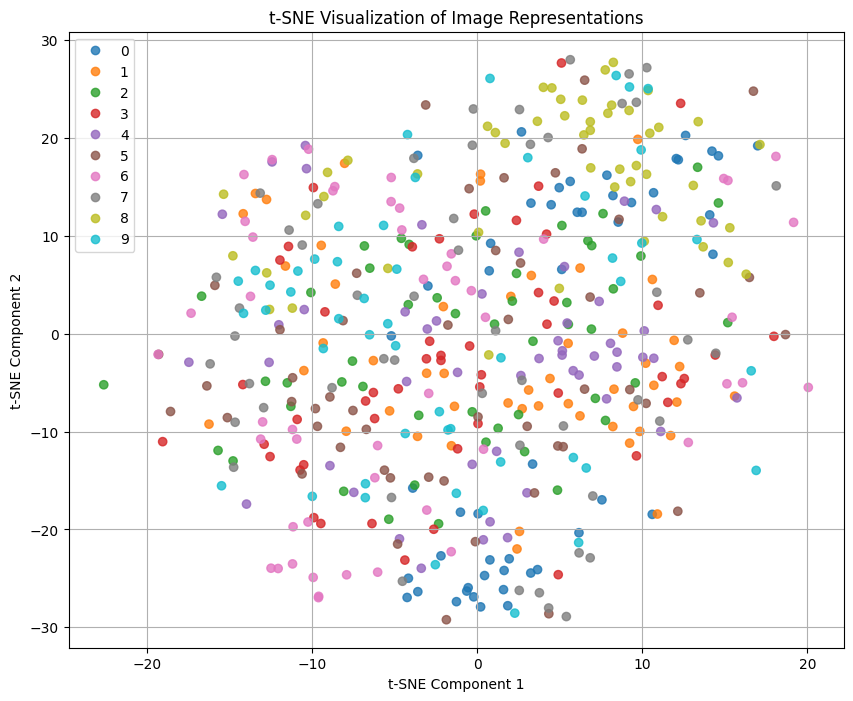

In [17]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# 1. Muat model terbaik yang telah disimpan
best_ckpt_path = os.path.join(args.log_dir, 'checkpoint_best.pth')
checkpoint = torch.load(best_ckpt_path, map_location=args.device)

model = ResNetSimCLR(base_model=args.arch, out_dim=args.out_dim)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(args.device)
model.eval()

backbone = model.backbone
backbone.fc = torch.nn.Identity()

# 2. Siapkan data loader untuk visualisasi
vis_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# --- PERBAIKAN 1: Gunakan folder 'train' bukan 'val' ---
data_dir_for_vis = os.path.join(args.data, 'train') 
vis_dataset = datasets.ImageFolder(root=data_dir_for_vis, transform=vis_transform)
# ----------------------------------------------------

# Ambil subset kecil untuk t-SNE (misalnya 1000 sampel dari 10 kelas)
num_classes_to_vis = 10
num_samples_per_class = 50  # Bisa diperbanyak jika perlu
subset_indices = []
targets_for_plot = []

# Dapatkan 'num_samples_per_class' gambar dari 'num_classes_to_vis' kelas pertama
for class_idx in range(num_classes_to_vis):
    # Cari semua indeks untuk kelas saat ini
    class_indices = [i for i, (img, target) in enumerate(vis_dataset) if vis_dataset.targets[i] == class_idx]
    # Ambil sampel dari indeks tersebut
    subset_indices.extend(class_indices[:num_samples_per_class])
    targets_for_plot.extend([class_idx] * num_samples_per_class)

subset_dataset = torch.utils.data.Subset(vis_dataset, subset_indices)
vis_loader = DataLoader(subset_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers)

# 3. Ekstrak fitur (representasi)
features_list = []
with torch.no_grad():
    for images, _ in vis_loader:
        images = images.to(args.device)
        features = backbone(images)
        features_list.append(features.cpu().numpy())

features_array = np.concatenate(features_list, axis=0)
n_samples = features_array.shape[0]

# --- PERBAIKAN 2: Atur perplexity secara dinamis ---
# Perplexity harus lebih kecil dari jumlah sampel
perplexity_value = min(30, n_samples - 1)
# -------------------------------------------------

print(f"Jumlah sampel untuk t-SNE: {n_samples}")
print(f"Nilai perplexity yang digunakan: {perplexity_value}")

# 4. Jalankan t-SNE dan plot hasilnya
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
features_tsne = tsne.fit_transform(features_array)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=targets_for_plot, cmap='tab10', alpha=0.8)
plt.title('t-SNE Visualization of Image Representations')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=range(num_classes_to_vis))
plt.grid(True)
plt.savefig('tsne_visualization.png')
print("Visualisasi t-SNE telah disimpan sebagai tsne_visualization.png")
plt.show()